# StilSucher

## Project Description

StilSucher is a semantic search engine for fashion items. The goal of this project is to create a search engine that allows users to search for images of fashion items using text (text2image). The search engine will use a text embedding encoder to convert the query text into a 512-dimensional vector and retrieve image embeddings stored in a Qdrant database that have the highest similarity. Both the text encoder and image encoder are from the FashionCLIP model, which is a fine-tuned version of CLIP for fashion items.

For StilSucher, We will be using FashionCLIP as my text and image embedding models. FashionCLIP is a model that was trained on the Fartfetch dataset (which was not disclosed at the moment of creating this notebook). As a dataset, we will be using the H&M dataset published on Kaggle for the RecSys competition. In this notebook, we will not be training a recommendation model, but we will be creating a Text2Image search engine using Qdrant.

The purpose of this notebook is to evaluate the performance of the different APIs that Qdrant provides to decide which one to use for the final implementation of the search engine. The text embedding model will be used to convert the query text into a 512-dimensional vector, and the image embedding model will be used to embed all the images and save them in my Qdrant Database.

Some Assumptions and Considerations:
- As a dataset, we will be using the H&M dataset published on Kaggle for the RecSys competition.
- I assume that the FashionCLIP model wasn't trained on the H&M dataset, so we can use the entire dataset as a test set to evaluate the performance of the different APIs.
- Although we will be using the search, recommend, and discover APIs that Qdrant provides, we will use them all for search.

## Data Processing and FashionCLIP Embeddings Creation

To make the process fast for testing, in this Notebook, I'll create all the necessary embeddings so we don't have to compute them each time when we want to run multiple tests. This notebook will:
- Download the dataset with all the images.
- Load the `csv` that contains the data organized in a way so we can test it with the different retrieval strategies offered by Qdrant.
- Generate the embeddings for images and text using FashionCLIP.
- Save them in a file that we can later use in our evaluations and in our final implementation.

<!-- important note with colored box -->
<font color='red'>**Important Note:**</font> This notebook can be rerun, but the resulting files with embeddings generated will be included in this repo so you don't have to run expensive computation to create them.

In [1]:
%%capture
!pip install gdown # Install gdown if not already installed
!gdown "1igAuIEW_4h_51BG1o05WS0Q0-Cp17_-t&confirm=t"
!unzip data

The dataset used is a sample that comes from [Kaggle](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations).  We report here data access and use found on Kaggle.

**A. Data Access and Use.**

Competition Use and Non-Commercial & Academic Research: You may access and use the Competition Data for non-commercial purposes only, including for participating in the Competition and on Kaggle.com forums, and for academic research and education. The Competition Sponsor reserves the right to disqualify any participant who uses the Competition Data other than as permitted by the Competition Website and these Rules.

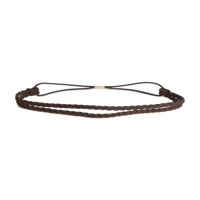

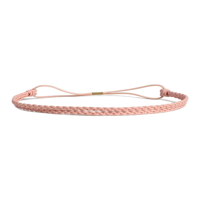

In [1]:
# show the two images with 176754003.jpg 176754019.jpg side by side, they are in the same folder as de articles.csv
from PIL import Image
from IPython.display import display

img1 = Image.open("data_for_fashion_clip/176754003.jpg")
img2 = Image.open("data_for_fashion_clip/176754019.jpg")

# Resize the images
resized_img1 = img1.resize((200, 200))
resized_img2 = img2.resize((200, 200))

display(resized_img1, resized_img2)

## The FashionCLIP Model 

Run this if you haven't installed all the packages in the `requirement.txt` file

In [4]:
# %%capture
!pip install -U fashion-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.8 MB/s eta 0:00:00
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552402 sha256=5c0b19d22d497f3c811f3caa17e45f546132023ae6b71bfd858516ec144006d6
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [5]:
import sys
#sys.path.append("fashion-clip/")
from fashion_clip.fashion_clip import FashionCLIP
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
import numpy as np
# from reclist.logs import LOGGER
# from reclist.metadata import METADATA_STORE
# from reclist.reclist import RecList
from random import randint, choice
import os
# from reclist.reclist import rec_test
# from reclist.charts import CHART_TYPE
from glob import glob
import json

Let's now create an instance of FashionCLIP first. It's going to take a couple of minutes to download the model from the HuggingFace Hub.

In [6]:
%%capture
fclip = FashionCLIP('fashion-clip')

Lets load the data and drop some elements to simplify the analysis.

In [7]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random
from collections import Counter

In [31]:
# Load the dataset
df = pd.read_csv("data_for_fashion_clip/articles.csv")


# --------------------------- We drop some elements to simplify things ---------------------------
# # keep only articles with unique descriptions
df = df.drop_duplicates("detail_desc").copy()

# # remove items of unkown category
df = df[~df["product_group_name"].isin(["Unknown"])]

# # FashionCLIP has a limit of 77 tokens, let's play it safe and drop things with more than 40 tokens
df = df[df["detail_desc"].apply(lambda x : 4 < len(str(x).split()) < 50)]

# # We also drop products types that do not occur very frequently in this subset of data
most_frequent_product_types = [k for k, v in dict(Counter(df["product_type_name"].tolist())).items() if v > 10]
df = df[df["product_type_name"].isin(most_frequent_product_types)]

# Reset the index to ensure it's continuous
df.reset_index(drop=True, inplace=True)
# ------------------------------------------------------------------------------------------------

# Select the columns of interest
# columns_of_interest = [
#     'product_type_name', 'product_group_name', 'graphical_appearance_name',
#     'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name',
#     'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name'
# ]
columns_of_interest = [
    'product_type_name', 'product_group_name',
    'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name',
    'department_name', 'garment_group_name'
]

len(df)

3335

In [32]:
# Select and encode the columns of interest
df_selected = df[columns_of_interest].fillna('Unknown')
encoder = OneHotEncoder(sparse_output=True)  # Use sparse=True for efficiency
df_encoded = encoder.fit_transform(df_selected)

# Calculate the cosine similarity matrix
cosine_sim = cosine_similarity(df_encoded, dense_output=False)  # Keep output sparse

# Ensure we don't self-match by setting diagonals to 0
cosine_sim.setdiag(0)
cosine_sim.eliminate_zeros()


## Creating Pairs for the Discovery and Recommendations APIs

We aim to evaluate whether the results provided by the APIs retrieve a target item. For the Discovery and Recommend retrieval strategies, we simulate smart users who can provide more useful information to improve the retrieval results. A naive approach to simulate this involves calculating the similarity between items based on their attributes (color, product type, etc). From the most similar items, we select the attributes that, if changed, will most increase the distance between the two items. Based on this, we rank the categories that most influence the increase in distance between these items, and pick the actual category value of that item as `positive` sample and a random one from that same category as the `negative` sample, to be later used for the Discovery and Recommendations APIs.

In [33]:
similarity_threshold = 0.9
most_similar_articles = []

for i in range(cosine_sim.shape[0]):
    row = cosine_sim[i].toarray().flatten()
    if np.max(row) > similarity_threshold:
        most_similar_index = np.argmax(row)
        most_similar_articles.append((i, most_similar_index, row[most_similar_index]))


In [34]:
# Placeholder for simplified impact calculation
# This step is highly conceptual and requires significant customization
def calculate_impact(article_index, similar_article_index, df_encoded, encoder, columns_of_interest):
    # Simplified: Return a random category as the most impactful for demonstration
    import random
    return random.choice(columns_of_interest)

# Using the function to estimate the most impactful category for each pair
impactful_categories = [calculate_impact(i, j, df_encoded, encoder, columns_of_interest) for i, j, _ in most_similar_articles]

# Calculate the influence of each category
from collections import Counter
category_counts = Counter(impactful_categories)
total = sum(category_counts.values())
category_influences = {cat: count / total * 100 for cat, count in category_counts.items()}


In [35]:
print("Category Influences on Article Similarity:")
# Sort the dictionary by influence in descending order
sorted_influences = sorted(category_influences.items(), key=lambda item: item[1], reverse=True)

for category, influence in sorted_influences:
    print(f"{category}: {influence:.2f}%")


Category Influences on Article Similarity:
product_type_name: 16.23%
garment_group_name: 15.20%
product_group_name: 14.72%
colour_group_name: 14.31%
department_name: 13.41%
perceived_colour_value_name: 13.41%
perceived_colour_master_name: 12.72%


In [36]:
import random

def weighted_random_selection(weights_dict):
    categories = list(weights_dict.keys())
    probabilities = [weights_dict[category] / 100 for category in categories]  # Convert percentages to probabilities
    return random.choices(categories, weights=probabilities, k=1)[0]

def select_different_value(df, article_index, category):
    original_value = df.iloc[article_index][category]
    possible_values = df[category].unique().tolist()
    possible_values.remove(original_value)
    if possible_values:  # Ensure there are other possible values
        return random.choice(possible_values)
    return original_value  # Fallback if no other values are available


In [37]:
enhanced_rows = []

for i, row in df.iterrows():
    category_selected = weighted_random_selection(category_influences)
    original_value = row[category_selected]
    negative_sample = select_different_value(df, i, category_selected)
    enhanced_detail_desc = f"{row['detail_desc']}, It has to be {original_value}, not {negative_sample}"

    enhanced_rows.append({
        'article_id': row['article_id'],
        'detail_desc': row['detail_desc'],
        'category_selected': category_selected,
        'positive': original_value,
        'negative': negative_sample,
        'enhanced_detail_desc': enhanced_detail_desc
    })

# Convert to DataFrame
articles_df = pd.DataFrame(enhanced_rows)

In [38]:
articles_df.head()

,article_id,detail_desc,category_selected,positive,negative,enhanced_detail_desc
0,108775044,Jersey top with narrow shoulder straps.,product_type_name,Vest top,Top,"Jersey top with narrow shoulder straps., It ha..."
1,176754003,Two-strand hairband with braids in imitation s...,product_group_name,Accessories,Garment Lower body,Two-strand hairband with braids in imitation s...
2,189634031,Leggings in stretch jersey with an elasticated...,product_type_name,Leggings/Tights,Hat/beanie,Leggings in stretch jersey with an elasticated...
3,194270044,Tops in soft organic cotton jersey.,garment_group_name,Jersey Basic,Unknown,"Tops in soft organic cotton jersey., It has to..."
4,203027047,Short-sleeved top in jersey with sewn-in turn-...,colour_group_name,White,Black,Short-sleeved top in jersey with sewn-in turn-...


## Embedding Everything

Now that the samples are organized, I create the embeddings

In [39]:
import numpy as np
import pandas as pd
import pickle
import os
from glob import glob
from tqdm.auto import tqdm

In [40]:
def generate_embeddings(comparison_df):
    print(len(comparison_df))
    # Extract necessary data for embedding generation
    parent_folder = "data_for_fashion_clip"

    images = [f"{parent_folder}/{aid}.jpg" for aid in comparison_df['article_id']]
    targets = comparison_df['detail_desc'].tolist()
    enhanced_targets = comparison_df['enhanced_detail_desc'].tolist()
    positives = comparison_df['positive'].tolist()
    negatives = comparison_df['negative'].tolist()

    # Generate embeddings
    image_embeddings = fclip.encode_images(images, batch_size=32)
    target_embeddings = fclip.encode_text(targets, batch_size=32)
    enhanced_target_embeddings = fclip.encode_text(enhanced_targets, batch_size=32)
    positive_embeddings = fclip.encode_text(positives, batch_size=32)
    negative_embeddings = fclip.encode_text(negatives, batch_size=32)

    # Normalizing everything
    image_embeddings = image_embeddings/np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
    target_embeddings = target_embeddings/np.linalg.norm(target_embeddings, ord=2, axis=-1, keepdims=True)
    enhanced_target_embeddings = enhanced_target_embeddings/np.linalg.norm(enhanced_target_embeddings, ord=2, axis=-1, keepdims=True)
    positive_embeddings = positive_embeddings/np.linalg.norm(positive_embeddings, ord=2, axis=-1, keepdims=True)
    negative_embeddings = negative_embeddings/np.linalg.norm(negative_embeddings, ord=2, axis=-1, keepdims=True)

    print(len(image_embeddings))
    return image_embeddings, target_embeddings, enhanced_target_embeddings, positive_embeddings, negative_embeddings

# Call the function and generate embeddings
embeddings = generate_embeddings(articles_df)

3335


105it [02:52,  1.65s/it]


Map:   0%|          | 0/3335 [00:00<?, ? examples/s]

105it [00:06, 15.21it/s]                         


Map:   0%|          | 0/3335 [00:00<?, ? examples/s]

105it [00:06, 15.06it/s]                         


Map:   0%|          | 0/3335 [00:00<?, ? examples/s]

105it [00:07, 14.98it/s]                         


Map:   0%|          | 0/3335 [00:00<?, ? examples/s]

105it [00:06, 15.00it/s]                         

3335


In [41]:
def organize_embeddings(data_df, embeddings, original_df):
    organized_data = []
    for idx, row in data_df.iterrows():
        # Retrieve the original row from the original dataframe to include as metadata
        original_row_data = original_df.loc[original_df['article_id'] == row['article_id']].iloc[0].to_dict()

        # Replace NaN, None, or 'undefined' values with 'UNKNOWN'
        original_row_data = {k: ('UNKNOWN' if pd.isna(v) or v == 'undefined' else v) for k, v in original_row_data.items()}

        organized_data.append({
            'id': str(row['article_id']),
            'target': embeddings[1][idx],
            'target_text': str(row['detail_desc']),
            'enhanced_target': embeddings[2][idx],
            'enhanced_target_text': str(row['enhanced_detail_desc']),
            'positive': embeddings[3][idx],
            'positive_text': str(row['positive']),
            'negative': embeddings[4][idx],
            'negative_text': str(row['negative']),
            'target_ground_truth_image': embeddings[0][idx],
            'metadata': original_row_data  # Add metadata here
        })
    return organized_data


# Organize the embeddings
organized_data = organize_embeddings(articles_df, embeddings, df)

In [42]:
len(organized_data)

3335

In [43]:
print(organized_data[0]['id'])
print(len(organized_data[0]['target_ground_truth_image']), type(organized_data[0]['target_ground_truth_image']))
organized_data[0]['metadata']

108775044
512 <class 'numpy.ndarray'>


{'article_id': 108775044,
 'product_code': 108775,
 'prod_name': 'Strap top',
 'product_type_no': 253,
 'product_type_name': 'Vest top',
 'product_group_name': 'Garment Upper body',
 'graphical_appearance_no': 1010016,
 'graphical_appearance_name': 'Solid',
 'colour_group_code': 10,
 'colour_group_name': 'White',
 'perceived_colour_value_id': 3,
 'perceived_colour_value_name': 'Light',
 'perceived_colour_master_id': 9,
 'perceived_colour_master_name': 'White',
 'department_no': 1676,
 'department_name': 'Jersey Basic',
 'index_code': 'A',
 'index_name': 'Ladieswear',
 'index_group_no': 1,
 'index_group_name': 'Ladieswear',
 'section_no': 16,
 'section_name': 'Womens Everyday Basics',
 'garment_group_no': 1002,
 'garment_group_name': 'Jersey Basic',
 'detail_desc': 'Jersey top with narrow shoulder straps.'}

In [44]:
def split_and_save_data(data, max_elements_per_file, base_filename="embedding"):
    for i in range(0, len(data), max_elements_per_file):
        chunk = data[i:i + max_elements_per_file]
        filename = f"{base_filename}_{i//max_elements_per_file}.pkl"
        with open(filename, "wb") as file:
            pickle.dump(chunk, file)
            print(f"Saved {filename}")

# Example usage: Adjust max_elements_per_file based on your needs to fit the 50MB limit
split_and_save_data(organized_data, max_elements_per_file=2000)

In [46]:
# split_and_save_data(organized_data, max_elements_per_file=4000, base_filename='unique_desc_article_embeddings')
split_and_save_data(organized_data, max_elements_per_file=4000, base_filename='article_embeddings')

Saved unique_desc_article_embeddings_0.pkl


In [ ]:
def load_embeddings(file_pattern="embedding_*.pkl"):
    all_data = []
    for filename in sorted(glob(file_pattern)):
        with open(filename, "rb") as file:
            all_data.extend(pickle.load(file))
    return all_data

# Example usage
all_data = load_embeddings()
# print(all_data[:1])
print(len(all_data))

Now that we have the embeddings, we can start testing the different APIs that Qdrant provides in the next notebook